## Closed-loop batch, constrained BO in botorch with qNEI

In this tutorial, we illustrate how to implement a simple Bayesian Optimization (BO) closed loop in botorch.

In general, we recommend for a relatively simple setup (like this one) to use Ax, since this will simplify your setup (including the amount of code you need to write) considerably. See the [Using botorch with Ax](../using_botorch_with_ax) tutorial.

However, you may want to do things that are not easily supported in Ax at this time (like running high-dimensional BO using a VAE+GP model that you jointly train on high-dimensional input data). If you find yourself in such a situation, you will need to write your own optimization loop, as we do in this tutorial.


We use the Noisy-EI (qNEI) acquisition function to optimize a constrained version of the synthetic Hartmann6 test function. The standard problem is

$$f(x) = -\sum_{i=1}^4 \alpha_i \exp \left( -\sum_{j=1}^6 A_{ij} (x_j - P_{ij})^2  \right)$$

over $x \in [0,1]^6$ (parameter values can be found in `botorch/test_functions/hartmann6.py`).

In real BO applications, the design $x$ can influence multiple metrics in unknown ways, and the decision-maker often wants to optimize one metric without sacrificing another. To illustrate this, we add a synthetic constarint fo the form $\|x\|_1 - 3 \le 0$. Both the objective and the constraint are observed with noise. 

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_{x} -f(x) = 3.32237$.

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

#### Problem setup

First, we define the constraint used in the example in `outcome_constraint`. The second function `weighted_obj` is a "feasibility-weighted objective," which returns zero when not feasible. 

In [2]:
from botorch.test_functions.hartmann6 import neg_hartmann6

def outcome_constraint(X):
    """L1 constraint; feasible if less than or equal to zero."""
    return X.sum(dim=-1) - 3

def weighted_obj(X):
    """Feasibility weighted objective; zero if not feasible."""
    return neg_hartmann6(X) * (outcome_constraint(X) <= 0).type_as(X)

#### Model initialization

We use a `MultiOutputGP` to model the objective (output 0) and the constraint (output 1). We assume known homoskedastic observation noise on both the objective and constraint with standard error $\sigma = 0.2$. 

Each component is a `ConstantNoiseGP`. The models are initialized with 10 training points drawn randomly from $[0,1]^6$.

In [3]:
from botorch.models import FixedNoiseGP, MultiOutputGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

NOISE_SE = 0.2
train_y_se = torch.tensor(NOISE_SE, device=device)


def initialize_model(n = 10):
    # generate training data
    train_x = torch.rand(10, 6, device=device, dtype=dtype)
    exact_obj = neg_hartmann6(train_x)
    exact_con = outcome_constraint(train_x)
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    best_observed_value = weighted_obj(train_x).max().item()
    
    # define models for objective and constraint
    model_obj = FixedNoiseGP(train_x, train_obj, train_y_se.expand_as(train_obj)).to(train_x)
    model_con = FixedNoiseGP(train_x, train_con, train_y_se.expand_as(train_con)).to(train_x)
    
    # combine into a multi-output GP model
    model = MultiOutputGP(gp_models=[model_obj, model_con])
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    return train_x, train_obj, train_con, mll, model, best_observed_value

We will also need to define mappings that take the outputs of the GP and return the objective and the constraint. In general, these can be any `Callable`, but here we simply need to index the correct output.

In [4]:
from botorch.acquisition.objective import ConstrainedMCObjective

def obj_callable(Z):
    return Z[..., 0]

def constraint_callable(Z):
    return Z[..., 1]

# define a feasibility-weighted objective for optimization
constrained_obj = ConstrainedMCObjective(
    objective=obj_callable,
    constraints=[constraint_callable],
)

#### Define a helper function that performs the essential BO step
The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. For this example, we'll use a small batch of $q=3$.

In [5]:
from botorch.optim import joint_optimize

BATCH_SIZE = 3
bounds = torch.tensor([[0.0]*6, [1.0]*6], device=device, dtype=dtype)

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    
    # optimize
    candidates = joint_optimize(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=10,
        raw_samples=50,
        options={"simple_init": True, "maxiter": 50},
    )

    # observe new values 
    new_x = candidates.detach()
    new_obj = neg_hartmann6(new_x)
    new_con = outcome_constraint(new_x)
    return new_x, new_obj, new_con

#### Perform Bayesian Optimization loop with qNEI
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


We run `N_TRIALS=10` independent trials of `N_BATCH=5` iterations. The acquisition function is approximated using `MC_SAMPLES=500` samples.

In [6]:
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.acquisition.sampler import SobolQMCNormalSampler
import time
import warnings

# warnings.filterwarnings('ignore')
N_TRIALS = 10
N_BATCH = 10
MC_SAMPLES = 500

verbose = False

best_observed_all, best_random_all = [], []


# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS}", end="")
    best_observed, best_random = [], []
    
    # call helper function to initialize model
    train_x, train_obj, train_con, mll, model, best_observed_value = initialize_model(n=10)
    
    best_observed.append(best_observed_value)
    best_random.append(best_observed_value)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.time()
        
        # fit the model
        fit_gpytorch_model(mll)
        
        # define the qNEI acquisition module using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        qNEI = qNoisyExpectedImprovement(
            model=model, 
            X_baseline=train_x,
            sampler=qmc_sampler, 
            objective=constrained_obj,
        )
        
        # optimize and get new observation
        new_x, new_obj, new_con = optimize_acqf_and_get_observation(qNEI)
            
        # update training points
        train_x = torch.cat((train_x, new_x))
        train_obj = torch.cat((train_obj, new_obj))
        train_con = torch.cat((train_con, new_con))
        
        # update progress
        rand_x = torch.rand(BATCH_SIZE, 6)
        next_random_best = weighted_obj(rand_x).max().item()
        best_random.append(max(best_random[-1], next_random_best))       
        best_value = weighted_obj(train_x).max().item()
        best_observed.append(best_value)
        
        # reinitialize the model so it is ready for fitting on next iteration
        model.reinitialize(
            train_Xs=[train_x, train_x], 
            train_Ys=[train_obj, train_con], 
            train_Y_ses=[train_y_se.expand_as(train_obj), train_y_se.expand_as(train_obj)]
        )
        
        t1 = time.time()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, NEI) = "
                f"({max(best_random):>4.2f}, {best_value:>4.2f}), time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all.append(best_observed)
    best_random_all.append(best_random)


Trial  1 of 10..........
Trial  2 of 10..........
Trial  3 of 10..........
Trial  4 of 10..........
Trial  5 of 10..........
Trial  6 of 10..........
Trial  7 of 10..........
Trial  8 of 10..........
Trial  9 of 10..........
Trial 10 of 10..........

#### Plot the results

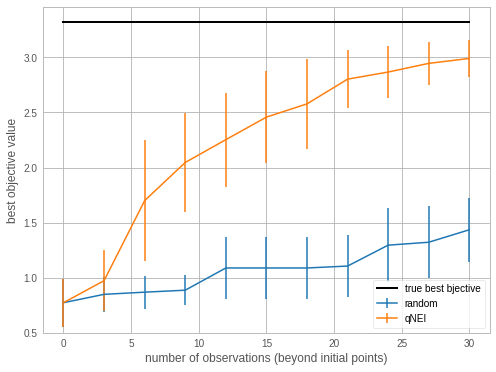

In [7]:
import numpy as np
from botorch.test_functions.hartmann6 import GLOBAL_MAXIMUM

from matplotlib import pyplot as plt
%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_nei = np.asarray(best_observed_all)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_nei.mean(axis=0), yerr=ci(y_nei), label="qNEI", linewidth=1.5)
plt.plot([0, N_BATCH * BATCH_SIZE], [GLOBAL_MAXIMUM] * 2, 'k', label="true best bjective", linewidth=2)
ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")